# Fase 6 - MIVA Unificado (Severidade Landis & Koch)

Esta fase substitui a consolidacao da Fase 4 e unifica os estudos empirico e sintetico com um unico criterio academico de severidade.

- **Metrica principal:** `delta_kappa = kappa_inicial - kappa_modelos`
- **Criterio de severidade unificado:** queda de faixas de concordancia de **Landis & Koch (1977)** entre `kappa_inicial` e `kappa_modelos`.
- **Criterio de amplificacao:** cenario amplificado quando ha **perda de pelo menos 1 faixa**.

Referencia:
- Landis JR, Koch GG (1977), *Biometrics*.




## 1) Setup (estilo e padrao de figuras)

Ajustes visuais alinhados ao padrao usado nas fases 2 e 3:
- estilo `seaborn-whitegrid` com paleta academica azul (Nature-like),
- tamanho de figura para pagina de dissertacao,
- exportaDelta kappao em **300 dpi**.




In [36]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------
# Estilo visual (coerente com fase 2)
# ---------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

NATURE_BLUE = '#0C4A6E'
NATURE_BLUE_MED = '#0284C7'
NATURE_BLUE_LIGHT = '#38BDF8'
NATURE_GRAY = '#64748B'
NATURE_ACCENT = '#1E3A5F'

SEV_COLORS = {
    'Ausente': '#6B7280',
    'Leve': '#0284C7',
    'Moderada': '#F59E0B',
    'Severa': '#DC2626'
}

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
})

# ---------------------------------------------------------------------
# Layout para dissertacao + publicacao
# ---------------------------------------------------------------------
FIG_W = 7.0
FIG_H = 5.0
HEAT_H = 5.8
DPI = 300

BASE = Path('data')
OUT = BASE / 'resultados_gerais' / 'fase6'
OUT.mkdir(parents=True, exist_ok=True)

PATH_EMP = BASE / 'resultados_gerais' / 'resumo_miva_empirico.csv'
PATH_EMP_SIG = BASE / 'resultados_empiricos' / 'significancia_delta_kappa.csv'
PATH_SINT = BASE / 'resultados_gerais' / 'resumo_miva_sintetico.csv'
PATH_SINT_STATS = BASE / 'resultados_sinteticos' / 'metricas_sinteticas_consolidadas.csv'



## 2) Regra academica unificada de severidade (Landis & Koch)

Faixas de kappa (Landis & Koch):
- `0.01-0.20`: Slight
- `0.21-0.40`: Fair
- `0.41-0.60`: Moderate
- `0.61-0.80`: Substantial
- `0.81-1.00`: Almost Perfect

Mapeamento para severidade MIVA pela **queda de faixas**:
- `0`: Ausente
- `1`: Leve
- `2`: Moderada
- `>=3`: Severa



In [37]:
LK_BANDS = [
    ('Poor', -1.0, 0.0),
    ('Slight', 0.0, 0.20),
    ('Fair', 0.20, 0.40),
    ('Moderate', 0.40, 0.60),
    ('Substantial', 0.60, 0.80),
    ('Almost Perfect', 0.80, 1.00),
]

LK_RANK = {name: i for i, (name, _, _) in enumerate(LK_BANDS)}


def lk_band(k):
    if pd.isna(k):
        return np.nan
    if k <= 0.0:
        return 'Poor'
    if k <= 0.20:
        return 'Slight'
    if k <= 0.40:
        return 'Fair'
    if k <= 0.60:
        return 'Moderate'
    if k <= 0.80:
        return 'Substantial'
    return 'Almost Perfect'


def sev_from_shift(shift):
    if shift <= 0:
        return 'Ausente'
    if shift == 1:
        return 'Leve'
    if shift == 2:
        return 'Moderada'
    return 'Severa'


def aplicar_miva_landis(df):
    out = df.copy()
    out['delta_kappa'] = out['kappa_inicial'] - out['kappa_modelos']
    out['faixa_inicial_lk'] = out['kappa_inicial'].apply(lk_band)
    out['faixa_modelo_lk'] = out['kappa_modelos'].apply(lk_band)
    out['rank_inicial_lk'] = out['faixa_inicial_lk'].map(LK_RANK)
    out['rank_modelo_lk'] = out['faixa_modelo_lk'].map(LK_RANK)
    out['faixas_perdidas'] = (out['rank_inicial_lk'] - out['rank_modelo_lk']).clip(lower=0)
    out['severidade'] = out['faixas_perdidas'].apply(sev_from_shift)
    out['amplificacao_detectada'] = out['faixas_perdidas'] > 0
    return out


## 3) Carga dos estudos e aplicacao da regra unificada



In [38]:
# Empirico
df_emp = pd.read_csv(PATH_EMP)
df_emp_sig = pd.read_csv(PATH_EMP_SIG)

# Sintetico
df_sint = pd.read_csv(PATH_SINT)
df_sint_stats = pd.read_csv(PATH_SINT_STATS)

# Aplica regra unificada
emp = aplicar_miva_landis(df_emp)
sint = aplicar_miva_landis(df_sint)

# Metadados de estudo/ cenario
emp['estudo'] = 'Empirico (MQD-1465)'
emp['cenario'] = emp['dataset'].astype(str) + ' | ' + emp['modelo'].astype(str)

sint['estudo'] = 'Sintetico (SynSA)'
sint['cenario'] = sint['dataset'].astype(str) + ' | ' + sint['modelo'].astype(str)

# Enriquecimento estatistico (empirico)
emp = emp.merge(
    df_emp_sig[['modelo', 'ic_95_lower', 'ic_95_upper', 'significativo', 'direcao']],
    on='modelo', how='left'
)

# Enriquecimento estatistico (sintetico)
# resumo_miva_sintetico ja costuma trazer p_value/cramers_v/chi2_stat;
# aqui so completamos o que estiver ausente.
stats_cols = ['chi2_stat', 'p_value', 'cramers_v']
missing_cols = [c for c in stats_cols if c not in sint.columns]

if missing_cols:
    sint_stats_model = df_sint_stats[df_sint_stats['fonte'] != 'Anotadores'].copy()
    sint_stats_model = sint_stats_model.rename(columns={'fonte': 'modelo'})
    cols_needed = ['dataset', 'modelo'] + [c for c in missing_cols if c in sint_stats_model.columns]
    sint = sint.merge(sint_stats_model[cols_needed], on=['dataset', 'modelo'], how='left')

# Seguran?a: se houver sufixos de merge (_x/_y), normaliza para nomes base.
for base in stats_cols:
    if base not in sint.columns:
        x = f'{base}_x'
        y = f'{base}_y'
        if x in sint.columns and y in sint.columns:
            sint[base] = sint[x].combine_first(sint[y])
        elif x in sint.columns:
            sint[base] = sint[x]
        elif y in sint.columns:
            sint[base] = sint[y]

drop_aux = [c for c in sint.columns if c.endswith('_x') or c.endswith('_y')]
if drop_aux:
    sint = sint.drop(columns=drop_aux)

print('Empirico:', emp.shape)
print('Sintetico:', sint.shape)
print('Colunas sintetico (checagem):', [c for c in ['chi2_stat','p_value','cramers_v'] if c in sint.columns])


Empirico: (4, 22)
Sintetico: (48, 20)
Colunas sintetico (checagem): ['chi2_stat', 'p_value', 'cramers_v']


## 4) Estudo empirico - cenarios amplificados (regra Landis & Koch)




In [39]:
emp_amp = emp[emp['amplificacao_detectada']].copy().sort_values('delta_kappa', ascending=False)

print('Cenarios empiricos totais:', len(emp))
print('Cenarios empiricos amplificados:', len(emp_amp))
print('Taxa de amplificacao:', f"{len(emp_amp)/len(emp):.1%}")

display(emp_amp[[
    'cenario', 'modelo', 'kappa_inicial', 'kappa_modelos', 'delta_kappa',
    'faixa_inicial_lk', 'faixa_modelo_lk', 'faixas_perdidas', 'severidade',
    'ic_95_lower', 'ic_95_upper', 'significativo', 'direcao'
]])




Cenarios empiricos totais: 4
Cenarios empiricos amplificados: 4
Taxa de amplificacao: 100.0%


,cenario,modelo,kappa_inicial,kappa_modelos,delta_kappa,faixa_inicial_lk,faixa_modelo_lk,faixas_perdidas,severidade,ic_95_lower,ic_95_upper,significativo,direcao
2,MQD-1209-MF | RF,RF,0.7652,0.437771,0.327429,Substantial,Moderate,1,Leve,0.287030,0.367925,True,AMPLIFICA
0,MQD-1209-MF | SVM,SVM,0.7652,0.464724,0.300476,Substantial,Moderate,1,Leve,0.261978,0.341105,True,AMPLIFICA
1,MQD-1209-MF | NB,NB,0.7652,0.486187,0.279013,Substantial,Moderate,1,Leve,0.241860,0.313977,True,AMPLIFICA
3,MQD-1209-MF | LR,LR,0.7652,0.498630,0.266570,Substantial,Moderate,1,Leve,0.229124,0.303330,True,AMPLIFICA


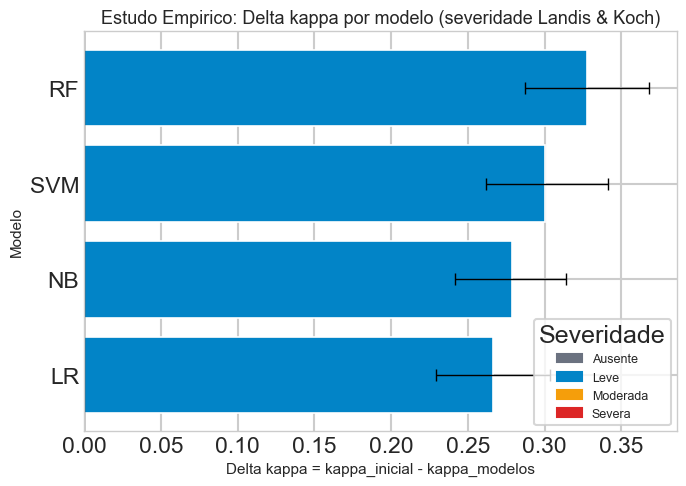

In [40]:
plot_df = emp.sort_values('delta_kappa', ascending=True).copy()
bar_colors = [SEV_COLORS[s] for s in plot_df['severidade']]

fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
ax.barh(plot_df['modelo'], plot_df['delta_kappa'], color=bar_colors, edgecolor='white', linewidth=1.2)

if {'ic_95_lower','ic_95_upper'}.issubset(plot_df.columns):
    ok = plot_df['ic_95_lower'].notna() & plot_df['ic_95_upper'].notna()
    if ok.any():
        yerr = [plot_df.loc[ok, 'delta_kappa'] - plot_df.loc[ok, 'ic_95_lower'],
                plot_df.loc[ok, 'ic_95_upper'] - plot_df.loc[ok, 'delta_kappa']]
        ax.errorbar(plot_df.loc[ok, 'delta_kappa'], plot_df.loc[ok, 'modelo'], xerr=yerr,
                    fmt='none', ecolor='black', capsize=4, linewidth=1)

ax.axvline(0, color='black', linewidth=1)
ax.set_title('Estudo Empirico: Delta kappa por modelo (severidade Landis & Koch)')
ax.set_xlabel('Delta kappa = kappa_inicial - kappa_modelos')
ax.set_ylabel('Modelo')

handles = [plt.Rectangle((0,0),1,1,color=SEV_COLORS[k]) for k in ['Ausente','Leve','Moderada','Severa']]
ax.legend(handles, ['Ausente','Leve','Moderada','Severa'], title='Severidade', loc='lower right', frameon=True)

plt.tight_layout()
fig.savefig(OUT / 'fase6_empirico_delta_landis.png', dpi=DPI, bbox_inches='tight')
plt.show()



## 5) Estudo sintetico - cenarios amplificados por concordancia controlada




In [41]:
sint_amp = sint[sint['amplificacao_detectada']].copy()

print('Cenarios sinteticos totais:', len(sint))
print('Cenarios sinteticos amplificados:', len(sint_amp))
print('Taxa de amplificacao:', f"{len(sint_amp)/len(sint):.1%}")

display(
    sint_amp[[
        'cenario', 'dataset', 'concordancia_alvo', 'modelo',
        'kappa_inicial', 'kappa_modelos', 'delta_kappa',
        'faixa_inicial_lk', 'faixa_modelo_lk', 'faixas_perdidas', 'severidade',
        'p_value', 'cramers_v'
    ]].sort_values('delta_kappa', ascending=False).head(24)
)




Cenarios sinteticos totais: 48
Cenarios sinteticos amplificados: 48
Taxa de amplificacao: 100.0%


,cenario,dataset,concordancia_alvo,modelo,kappa_inicial,kappa_modelos,delta_kappa,faixa_inicial_lk,faixa_modelo_lk,faixas_perdidas,severidade,p_value,cramers_v
10,SynSA-95 | RF,SynSA-95,95,RF,0.924925,0.162107,0.762818,Almost Perfect,Slight,4,Severa,4.988762e-12,0.171666
6,SynSA-97 | RF,SynSA-97,97,RF,0.954955,0.202221,0.752734,Almost Perfect,Fair,3,Severa,4.170705e-17,0.203730
2,SynSA-99 | RF,SynSA-99,99,RF,0.984985,0.250307,0.734678,Almost Perfect,Fair,3,Severa,1.257870e-26,0.252731
14,SynSA-90 | RF,SynSA-90,90,RF,0.849849,0.157114,0.692735,Almost Perfect,Slight,4,Severa,2.674927e-10,0.159177
18,SynSA-85 | RF,SynSA-85,85,RF,0.774775,0.178660,0.596115,Substantial,Slight,3,Severa,1.306224e-13,0.182296
22,SynSA-80 | RF,SynSA-80,80,RF,0.699699,0.152306,0.547393,Substantial,Slight,3,Severa,5.458685e-10,0.156827
26,SynSA-75 | RF,SynSA-75,75,RF,0.624623,0.141477,0.483147,Substantial,Slight,3,Severa,1.461100e-08,0.145465
13,SynSA-90 | NB,SynSA-90,90,NB,0.849849,0.389606,0.460243,Almost Perfect,Fair,3,Severa,5.993692e-66,0.394191
12,SynSA-90 | SVM,SynSA-90,90,SVM,0.849849,0.394143,0.455707,Almost Perfect,Fair,3,Severa,3.803942e-66,0.394772
8,SynSA-95 | SVM,SynSA-95,95,SVM,0.924925,0.470371,0.454554,Almost Perfect,Moderate,2,Moderada,1.200549e-94,0.471050


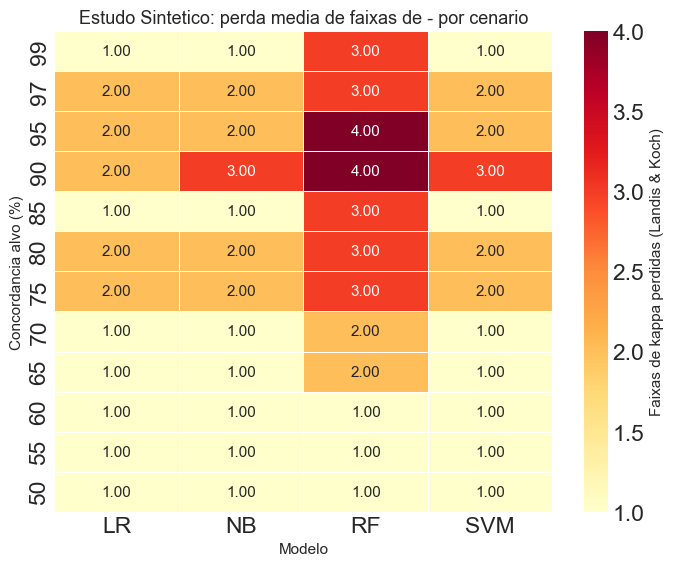

In [42]:
# Heatmap de faixas perdidas (criterio academico)
heat_shift = sint.pivot_table(
    index='concordancia_alvo', columns='modelo', values='faixas_perdidas', aggfunc='mean'
).sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(FIG_W, HEAT_H))
sns.heatmap(
    heat_shift, annot=True, fmt='.2f', cmap='YlOrRd', linewidths=0.4,
    cbar_kws={'label': 'Faixas de kappa perdidas (Landis & Koch)'}, ax=ax
)
ax.set_title('Estudo Sintetico: perda media de faixas de - por cenario')
ax.set_xlabel('Modelo')
ax.set_ylabel('Concordancia alvo (%)')

plt.tight_layout()
fig.savefig(OUT / 'fase6_sintetico_heatmap_faixas_perdidas.png', dpi=DPI, bbox_inches='tight')
plt.show()




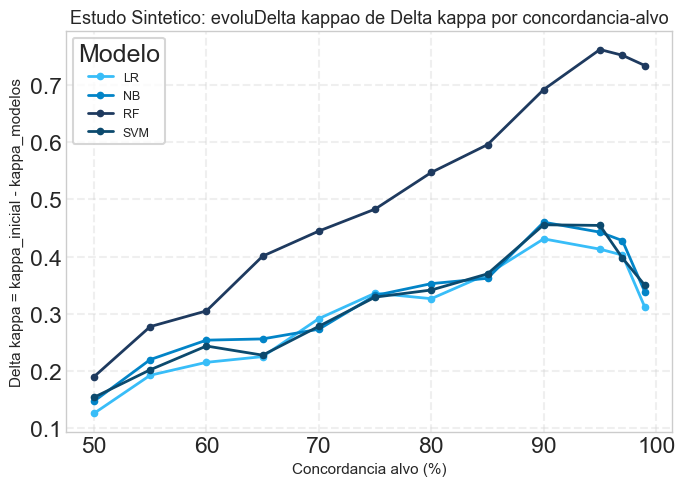

In [43]:
# Curvas de Delta kappa no sintetico (estilo de publicacao)
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
palette = {'LR': NATURE_BLUE_LIGHT, 'NB': NATURE_BLUE_MED, 'SVM': NATURE_BLUE, 'RF': NATURE_ACCENT}

for modelo, g in sint.groupby('modelo'):
    g = g.sort_values('concordancia_alvo')
    ax.plot(g['concordancia_alvo'], g['delta_kappa'], marker='o', linewidth=2,
            markersize=4.5, label=modelo, color=palette.get(modelo, NATURE_GRAY))

ax.set_title('Estudo Sintetico: evoluDelta kappao de Delta kappa por concordancia-alvo')
ax.set_xlabel('Concordancia alvo (%)')
ax.set_ylabel('Delta kappa = kappa_inicial - kappa_modelos')
ax.legend(title='Modelo', frameon=True)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
fig.savefig(OUT / 'fase6_sintetico_curvas_delta.png', dpi=DPI, bbox_inches='tight')
plt.show()




## 6) Unificacao final - cenarios amplificados (reais e sinteticos)




In [44]:
cols_base = [
    'estudo', 'cenario', 'dataset', 'modelo',
    'kappa_inicial', 'kappa_modelos', 'delta_kappa',
    'faixa_inicial_lk', 'faixa_modelo_lk', 'faixas_perdidas',
    'severidade', 'amplificacao_detectada'
]

emp_u = emp[cols_base + ['ic_95_lower', 'ic_95_upper', 'significativo', 'direcao']].copy()
emp_u['concordancia_alvo'] = np.nan
emp_u['p_value'] = np.nan
emp_u['cramers_v'] = np.nan

sint_u = sint[cols_base + ['concordancia_alvo', 'p_value', 'cramers_v', 'chi2_stat']].copy()
sint_u['ic_95_lower'] = np.nan
sint_u['ic_95_upper'] = np.nan
sint_u['significativo'] = np.nan
sint_u['direcao'] = np.nan

unif = pd.concat([emp_u, sint_u], ignore_index=True)
unif_amp = unif[unif['amplificacao_detectada']].copy().sort_values(['estudo', 'delta_kappa'], ascending=[True, False])

resumo_estudo = (
    unif.groupby('estudo', as_index=False)
    .agg(
        cenarios_total=('cenario', 'count'),
        cenarios_amplificados=('amplificacao_detectada', 'sum'),
        taxa_amplificacao=('amplificacao_detectada', 'mean'),
        delta_medio=('delta_kappa', 'mean'),
        delta_mediano=('delta_kappa', 'median'),
        faixas_perdidas_media=('faixas_perdidas', 'mean'),
    )
)

sev = (
    unif.groupby(['estudo', 'severidade'], as_index=False)
    .size()
    .rename(columns={'size': 'n'})
)
sev['pct'] = 100 * sev['n'] / sev.groupby('estudo')['n'].transform('sum')

print('Resumo por estudo:')
display(resumo_estudo)

print()
print('Distribuicao de severidade por estudo:')
display(sev.sort_values(['estudo', 'severidade']))

print()
print('Cenarios amplificados (visao unificada):')
display(unif_amp[[
    'estudo', 'cenario', 'modelo', 'concordancia_alvo',
    'delta_kappa', 'faixa_inicial_lk', 'faixa_modelo_lk',
    'faixas_perdidas', 'severidade'
]])


Resumo por estudo:


,estudo,cenarios_total,cenarios_amplificados,taxa_amplificacao,delta_medio,delta_mediano,faixas_perdidas_media
0,Empirico (MQD-1465),4,4,1.0,0.293372,0.289744,1.000000
1,Sintetico (SynSA),48,48,1.0,0.364275,0.339442,1.729167



Distribuicao de severidade por estudo:


,estudo,severidade,n,pct
0,Empirico (MQD-1465),Leve,4,100.00
1,Sintetico (SynSA),Leve,24,50.00
2,Sintetico (SynSA),Moderada,15,31.25
3,Sintetico (SynSA),Severa,9,18.75



Cenarios amplificados (visao unificada):


,estudo,cenario,modelo,concordancia_alvo,delta_kappa,faixa_inicial_lk,faixa_modelo_lk,faixas_perdidas,severidade
2,Empirico (MQD-1465),MQD-1209-MF | RF,RF,NaN,0.327429,Substantial,Moderate,1,Leve
0,Empirico (MQD-1465),MQD-1209-MF | SVM,SVM,NaN,0.300476,Substantial,Moderate,1,Leve
1,Empirico (MQD-1465),MQD-1209-MF | NB,NB,NaN,0.279013,Substantial,Moderate,1,Leve
3,Empirico (MQD-1465),MQD-1209-MF | LR,LR,NaN,0.266570,Substantial,Moderate,1,Leve
14,Sintetico (SynSA),SynSA-95 | RF,RF,95.0,0.762818,Almost Perfect,Slight,4,Severa
10,Sintetico (SynSA),SynSA-97 | RF,RF,97.0,0.752734,Almost Perfect,Fair,3,Severa
6,Sintetico (SynSA),SynSA-99 | RF,RF,99.0,0.734678,Almost Perfect,Fair,3,Severa
18,Sintetico (SynSA),SynSA-90 | RF,RF,90.0,0.692735,Almost Perfect,Slight,4,Severa
22,Sintetico (SynSA),SynSA-85 | RF,RF,85.0,0.596115,Substantial,Slight,3,Severa
26,Sintetico (SynSA),SynSA-80 | RF,RF,80.0,0.547393,Substantial,Slight,3,Severa


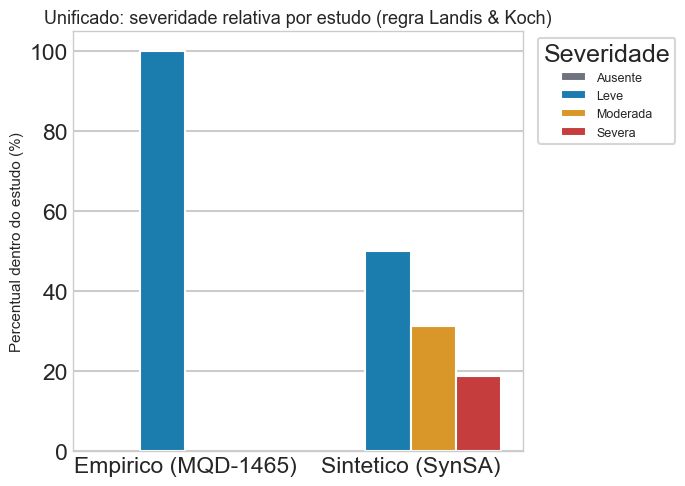

In [45]:
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
sev_order = ['Ausente', 'Leve', 'Moderada', 'Severa']
sev_plot = sev.copy()
sev_plot['severidade'] = pd.Categorical(sev_plot['severidade'], categories=sev_order, ordered=True)
sev_plot = sev_plot.sort_values('severidade')

sns.barplot(
    data=sev_plot, x='estudo', y='pct', hue='severidade',
    palette=[SEV_COLORS[s] for s in sev_order], ax=ax
)
ax.set_title('Unificado: severidade relativa por estudo (regra Landis & Koch)')
ax.set_xlabel('')
ax.set_ylabel('Percentual dentro do estudo (%)')
ax.legend(title='Severidade', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

plt.tight_layout()
fig.savefig(OUT / 'fase6_unificado_severidade_landis.png', dpi=DPI, bbox_inches='tight')
plt.show()


## 7) Sintese automatica e export de resultados




In [46]:
emp_row = resumo_estudo[resumo_estudo['estudo'] == 'Empirico (MQD-1465)'].iloc[0]
sint_row = resumo_estudo[resumo_estudo['estudo'] == 'Sintetico (SynSA)'].iloc[0]

print('Estudo empirico:')
print(f"- {int(emp_row['cenarios_amplificados'])}/{int(emp_row['cenarios_total'])} cenarios amplificados ({emp_row['taxa_amplificacao']:.1%}).")
print(f"- Delta kappa medio = {emp_row['delta_medio']:.3f}; faixas perdidas (media) = {emp_row['faixas_perdidas_media']:.2f}.")

print()
print('Estudo sintetico:')
print(f"- {int(sint_row['cenarios_amplificados'])}/{int(sint_row['cenarios_total'])} cenarios amplificados ({sint_row['taxa_amplificacao']:.1%}).")
print(f"- Delta kappa medio = {sint_row['delta_medio']:.3f}; faixas perdidas (media) = {sint_row['faixas_perdidas_media']:.2f}.")

print()
print('Maior amplificacao por estudo:')
for est, g in unif_amp.groupby('estudo'):
    top = g.sort_values('delta_kappa', ascending=False).iloc[0]
    print(f"- {est}: {top['cenario']} | Delta kappa={top['delta_kappa']:.3f} | perda de faixas={int(top['faixas_perdidas'])} | severidade={top['severidade']}")

# Export
unif.to_csv(OUT / 'fase6_unificado_todos_cenarios_landis.csv', index=False)
unif_amp.to_csv(OUT / 'fase6_unificado_cenarios_amplificados_landis.csv', index=False)
resumo_estudo.to_csv(OUT / 'fase6_unificado_resumo_por_estudo_landis.csv', index=False)
sev.to_csv(OUT / 'fase6_unificado_severidade_por_estudo_landis.csv', index=False)

print()
print('Arquivos exportados em:', OUT)
for p in sorted(OUT.glob('*landis*')):
    print('-', p.name)


Estudo empirico:
- 4/4 cenarios amplificados (100.0%).
- Delta kappa medio = 0.293; faixas perdidas (media) = 1.00.

Estudo sintetico:
- 48/48 cenarios amplificados (100.0%).
- Delta kappa medio = 0.364; faixas perdidas (media) = 1.73.

Maior amplificacao por estudo:
- Empirico (MQD-1465): MQD-1209-MF | RF | Delta kappa=0.327 | perda de faixas=1 | severidade=Leve
- Sintetico (SynSA): SynSA-95 | RF | Delta kappa=0.763 | perda de faixas=4 | severidade=Severa

Arquivos exportados em: data\resultados_gerais\fase6
- fase6_empirico_delta_landis.png
- fase6_unificado_cenarios_amplificados_landis.csv
- fase6_unificado_resumo_por_estudo_landis.csv
- fase6_unificado_severidade_landis.png
- fase6_unificado_severidade_por_estudo_landis.csv
- fase6_unificado_todos_cenarios_landis.csv
